In [7]:
# Import Important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [8]:
# Mock dataset construction
np.random.seed(42)
tabular_data = pd.DataFrame({
    'age': np.random.randint(20, 60, 100),
    'income': np.random.rand(100) * 100000,
    'gender': np.random.choice(['male', 'female'], 100),
})

text_data = pd.Series(np.random.choice([
    "This product is great.",
    "Worst experience ever.",
    "I love it.",
    "Not bad, not good.",
    "Highly recommend this item."], size=100))

image_data = np.random.rand(100, 64)  # Simulated flat grayscale images (8x8)
y = np.random.choice([0, 1], 100)

In [9]:
# Custom Transformers
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    def transform(self, X):
        return self.vectorizer.transform(X).toarray()

class ImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.reducer = PCA(n_components=10)
    def fit(self, X, y=None):
        self.reducer.fit(X)
        return self
    def transform(self, X):
        return self.reducer.transform(X)

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, idx):
        self.idx = idx
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        col = [x[self.idx] for x in X]
        if isinstance(col[0], dict):
            return pd.DataFrame(col)
        elif isinstance(col[0], str):
            return pd.Series(col)
        else:
            return np.array(col)


In [10]:
# Tabular preprocessing
tabular_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ["age", "income"]),
    ("cat", OneHotEncoder(), ["gender"])
])

In [11]:
# Feature union across modalities
feature_union = FeatureUnion([
    ("tabular", Pipeline([
        ("extract", ColumnExtractor(0)),
        ("tab_proc", tabular_preprocessor)
    ])),
    ("text", Pipeline([
        ("extract", ColumnExtractor(1)),
        ("text_proc", TextTransformer())
    ])),
    ("image", Pipeline([
        ("extract", ColumnExtractor(2)),
        ("img_proc", ImageTransformer())
    ]))
])

In [12]:
# Final model pipeline
full_pipeline = Pipeline([
    ("features", feature_union),
    ("clf", LogisticRegression(max_iter=1000))
])

In [13]:
# Train-test split
X_combined = list(zip(tabular_data.to_dict(orient="records"), text_data, image_data))
train_data, test_data, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [14]:
# Fit and evaluate
full_pipeline.fit(train_data, y_train)
y_pred = full_pipeline.predict(test_data)
accuracy = full_pipeline.score(test_data, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5500


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

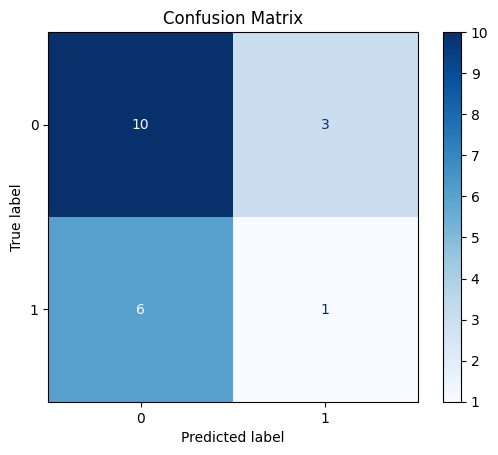

In [15]:
# Visualizations

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.77      0.69        13
           1       0.25      0.14      0.18         7

    accuracy                           0.55        20
   macro avg       0.44      0.46      0.44        20
weighted avg       0.49      0.55      0.51        20



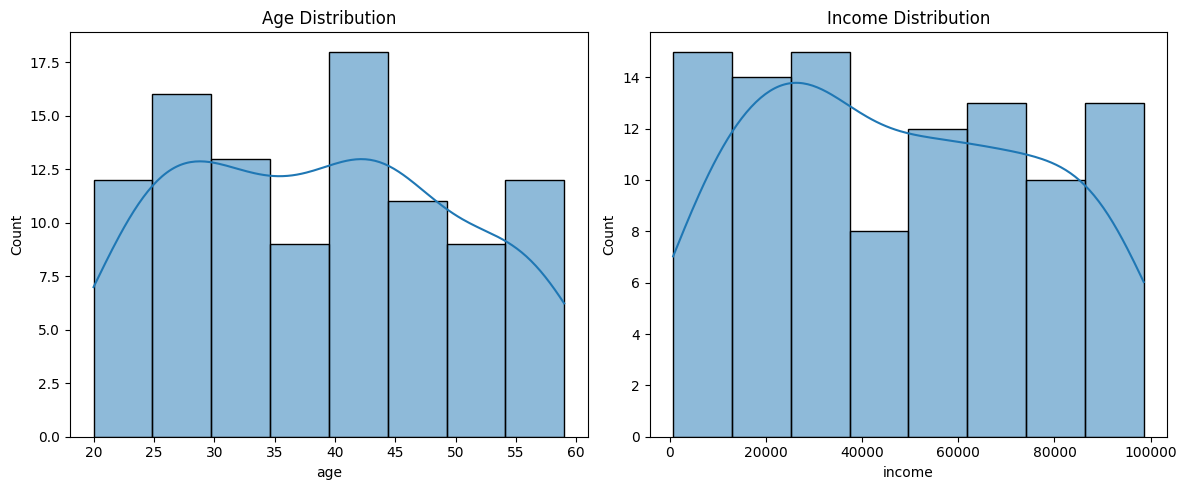

In [16]:
# 2. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 3. Distribution of Tabular Features
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(tabular_data['age'], kde=True, ax=axs[0])
axs[0].set_title("Age Distribution")
sns.histplot(tabular_data['income'], kde=True, ax=axs[1])
axs[1].set_title("Income Distribution")
plt.tight_layout()
plt.show()


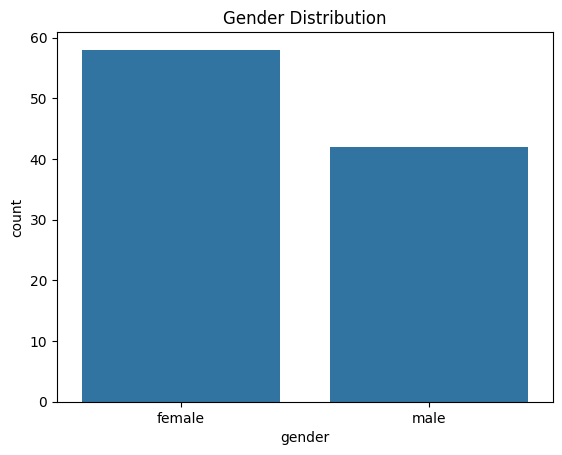

In [17]:
# 4. Gender Distribution
sns.countplot(x='gender', data=tabular_data)
plt.title("Gender Distribution")
plt.show()

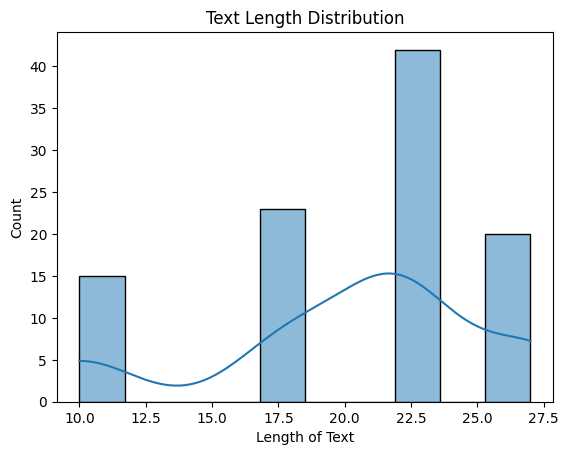

In [18]:
# 5. Text Length Distribution
text_lengths = text_data.apply(len)
sns.histplot(text_lengths, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Length of Text")
plt.show()

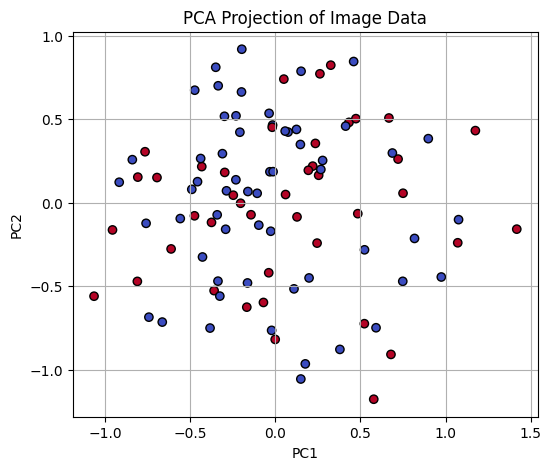

In [19]:
# 6. PCA Components of Images
image_pca = PCA(n_components=2).fit_transform(image_data)
plt.figure(figsize=(6, 5))
plt.scatter(image_pca[:, 0], image_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("PCA Projection of Image Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

---

### Papers Supporting Multimodal Fusion of Tabular, Text, and Image Data

* **"Bag of Tricks for Multimodal AutoML with Image, Text, and Tabular Data"** (Tang et al., 2024)
  Conducts an empirical study of best practices in multimodal learning—covering fusion strategies (early vs. late, parallel vs. sequential), augmentation, missing modality handling, and benchmark evaluation across 22 datasets combining all three modalities. Supports the design of unified pipelines using modular feature processing techniques. ([MDPI][1], [arXiv][2])

* **"AutoGluon-Multimodal (AutoMM)"** (Tang et al., 2024)
  Introduces an AutoML framework that natively handles multimodal inputs—tabular, text, and image—within a unified, scikit-compatible pipeline. This mirrors your approach in structuring and preprocessing diverse modalities under a single model architecture. ([arXiv][3])

* **"Revisiting Multimodal Transformers for Tabular Data with Text Fields"** (Bonnier, 2024)
  Proposes a dual-stream transformer architecture (Tabular‑Text Transformer) that employs attention mechanisms to fuse numerical and textual modalities effectively. Reinforces the theoretical value of parallel modality-specific pipelines and attention-based fusion—applicable to your scikit-learn pipeline analog. ([aclanthology.org][4])

* **"MUG: A Multimodal Classification Benchmark on Game ..."** (Lu et al., 2023)
  Presents a benchmark dataset (MUG) containing tabular, textual, and visual features targeted at multimodal classification tasks. Lends empirical justification for pipelines combining all three modalities, similar to your synthesized project. ([aclanthology.org][5])

---

### Broader Context in Multimodal Representation Learning

* **"Multimodal Representation Learning"** – IEEE Survey (Guo et al., 2019)
  Reviews foundational techniques like CCA, kernel CCA, deep canonical correlation analysis, graph-based fusion, and shared latent spaces. Highlights the theoretical underpinnings of integrating heterogeneous data modalities into unified representations—relevant to your pipeline’s fusion strategy. ([en.wikipedia.org][6])

---

### Summary Table

| Paper / Approach                              | Contribution to Your Pipeline Project                                                                |
| --------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| **Bag of Tricks… (Tang et al., 2024)**        | Empirical guidance on best practices in multimodal fusion (trick-based pipeline design)              |
| **AutoGluon-Multimodal (AutoMM, 2024)**       | Framework supporting seamless multimodal integration in ML pipelines                                 |
| **Tabular-Text Transformer (Bonnier, 2024)**  | Dual-stream fusion architecture via attention—aligns with parallel modality processing               |
| **MUG Benchmark (Lu et al., 2023)**           | Demonstrates necessity for pipelines that handle tabular + text + visuals in ML classification tasks |
| **Multimodal Representation Learning Survey** | Theoretical foundation on unified embeddings and modality fusion strategies                          |

---

[1]: https://www.mdpi.com/2673-2688/6/4/72?utm_source=chatgpt.com "Multimodal Data Fusion for Tabular and Textual Data: Zero ..."
[2]: https://arxiv.org/abs/2412.16243?utm_source=chatgpt.com "Bag of Tricks for Multimodal AutoML with Image, Text, and Tabular Data"
[3]: https://arxiv.org/pdf/2404.16233?utm_source=chatgpt.com "AutoGluon-Multimodal (AutoMM)"
[4]: https://aclanthology.org/2024.findings-acl.87.pdf?utm_source=chatgpt.com "Revisiting Multimodal Transformers for Tabular Data with ..."
[5]: https://aclanthology.org/2023.findings-emnlp.354.pdf?utm_source=chatgpt.com "MUG: A Multimodal Classification Benchmark on Game ..."
[6]: https://en.wikipedia.org/wiki/Multimodal_representation_learning?utm_source=chatgpt.com "Multimodal representation learning"
